# Latent semantic Analysis for Topic Modeling

In [ ]:
# Import statements
import pandas as pd
from gensim import corpora
from gensim.models import LsiModel
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from gensim.models.phrases import Phrases, Phraser
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import normalize
from gensim.corpora import Dictionary, MmCorpus
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
import torch
from collections import defaultdict
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
"""
  Load the corpus data from a CSV file. Ensures the dataframe contains no
  NaN/Null values and then converts the text content to a list. Gensim
  classes work on a list of the documents from the entire corpus instead
  of a dataframe/pandas series.

  Input  : file_path : path to the CSV file
           text_column : name of the column containing text data
  Output : list of sentences
"""
def load_data_from_csv(file_path, text_column):
    df = pd.read_csv(file_path)
    documents_list = df[text_column].dropna().tolist()
    return documents_list

In [ ]:
"""
  Tokenize the documents and return it as a list.
  Input  : document list
  Output : Tokenized text
"""
def tokenize_docs(doc_set):
    tokenizer = RegexpTokenizer(r'\w+')
    texts = []
    for i in doc_set:
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        texts.append(tokens)
    return texts

In [ ]:
"""
  Apply bigrams and trigrams in the tokenized text
  Input  : document list
  Output : Tokenized text
"""
def phrasing(doc_clean):
  bigram = Phrases(doc_clean, threshold = 10)
  bigrammify = Phraser(bigram)
  bigram_docs = [bigrammify[doc] for doc in doc_clean]
  return bigram_docs

In [ ]:
"""
  Create term dictionary of our corpus and convert the tokenized corpus
  into a TFIDF Matrix. Calls the Dictionary class and provides a dictionary
  of each known word in the corpus along with its unique integer ID (str, int).
  A list holds the Bag of Words (BoW) format of each document in the corpus
  (token ID, token count). The BoW is then transformed to a TFIDF matrix.

  the `smartirs` parameter for tfidf is a mnemonic scheme where:
  `n`: Uses the raw count of term occurrences in the document and entails
       how the term frequency is computed
  `p`: Dictates the document frequency calculation through a probabilistic
       IDF -> log((N - d)/ d) where `N` is the total number of docs and `d`
       is the num of documents containing a particular term.
  `u`: The final document vector is normalized by the number of unique words
       in the document (as Pivoted Unique Normalization)

  Input  : documents_list from `load_data_from_csv`
  Output : term dictionary and TFIDF Matrix
"""
def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    bow_corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
    tfidf = TfidfModel(corpus = bow_corpus, smartirs = 'npu')
    tfidf_matrix = tfidf[bow_corpus]
    return dictionary, tfidf_matrix

In [ ]:
"""
  Method for creating the LSA model via the gensim library. Under the hood,
  Latent Semantic Analysis uses Singular Value Decomposition to decompose a
  Matrix `M` = d x n  where: `d` = no. of documents & `n`= no. of terms
  To three different matrices: U, ∑, and transpose of V
  U = n x k where:  `k` no. of topics,
  ∑ = k x k,
  V Transpose = k x d

  SVD reduces the size of the original tfidf matrix by truncating
  the decomposed matrices to retain the top `k` most important topics.
  The documents and words are represented as vectors in a latent space
  of "topics" and each dimension is a topic.

  `lsamodel.print_topics` gets the number of topics as `k` and  the top `n`
  number of words related to each topic ordered by significance.

  Input  : clean document, number of topics and number of words associated with
           each topic
  Output : return LSA model, dictionary, and tfidf matrix
"""
def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    dictionary, tfidf_matrix = prepare_corpus(doc_clean)
    lsamodel = LsiModel(tfidf_matrix, num_topics = number_of_topics,
                        id2word = dictionary, random_seed = 10)
    # Print the topics and their respective terms
    topics = lsamodel.print_topics(num_words = words)
    for idx, topic in topics:
      print(f"Topic {idx}:")
      words = topic.split(" + ")
      for word in words:
          print(f"\t{word}")
      print('')
    return lsamodel, dictionary, tfidf_matrix

In [ ]:
"""
  Iterates through a number of topics `stop`;
  creates a Latent Semantic Analysis (same as LSI) model that takes in
  the tfidf sparse matrix, the number of topics based on the
  current value of `stop`, and the dictionary. This calculates the topic
  coherence of each model. The model with the highest coherence value is the
  best performing LSA model.

  Input   : dictionary : Gensim dictionary
            tfidf_matrix : Gensim corpus
            doc_clean : List of input texts
            stop : Max num of topics
  Output  : model_list : List of LSA topic models
            coherence_values : Coherence values corresponding to the LSA model
            with respective number of topics
"""
def compute_coherence_values(dictionary, coherence, tfidf_matrix, doc_clean,
                             stop, start = 2, step = 3):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, stop, step):
        model = LsiModel(tfidf_matrix, num_topics = num_topics,
                         id2word = dictionary, random_seed = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model,
                                        texts = doc_clean,
                                        dictionary = dictionary,
                                        coherence = coherence)
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)

    max_coherence_value = max(coherence_values)
    best_num_topics = num_topics_list[coherence_values.index(max_coherence_value)]
    print(f"Best C_V Coherence Value: {max_coherence_value}")
    print(f"Optimal no. of Topics with Highest Coherence: {best_num_topics}")
    return model_list, coherence_values

In [ ]:
'''
  Plots the a graph showing the coherence values of each generated LSA model.
  The data interpreted from this would allow us to identify the best performing
  model based on its number of topics.
    Input   : doc_clean : The corpus
              start : The first number of topics
              stop : Max num of topics
              step: number of values to traverse through the range of values.
'''

def plot_graph(doc_clean, coherence, start, stop, step):
    dictionary, tfidf_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary,
                                                            coherence,
                                                            tfidf_matrix,
                                                            doc_clean,
                                                            stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc = 'best')
    plt.show()

In [ ]:
# Helper methods for calculating the silhouette scores
def compute_silhouette_scores(doc_clean, start, stop, step):
    silhouette_scores = []
    num_topics_list = []

    dictionary, tfidf_matrix = prepare_corpus(doc_clean)

    for num_topics in range(start, stop, step):
        # Create the LSA model for each number of topics
        lsamodel = LsiModel(tfidf_matrix, num_topics = num_topics,
                            id2word = dictionary, random_seed = 10)

        # Get the topic distribution for each document (document-topic matrix)
        corpus_lsa = lsamodel[tfidf_matrix]

        # Convert the LSA projection to a dense matrix (document-topic representation)
        doc_topic_matrix = []
        for doc in corpus_lsa:
            vector = [0] * num_topics
            for idx, score in doc:
                vector[idx] = score
            doc_topic_matrix.append(vector)

        # Normalize the document-topic matrix
        doc_topic_matrix = np.array(doc_topic_matrix)
        doc_topic_matrix = normalize(doc_topic_matrix)

        # Calculate the Silhouette Score using the document-topic matrix
        current_score = silhouette_score(doc_topic_matrix,
                                 np.argmax(doc_topic_matrix, axis = 1))
        silhouette_scores.append(current_score)
        num_topics_list.append(num_topics)

    return silhouette_scores, num_topics_list

# Plot the Silhouette Score vs Number of Topics
def plot_silhouette_scores(doc_clean, start, stop, step):
    silhouette_scores, num_topics_list = compute_silhouette_scores(doc_clean, start, stop, step)

    plt.plot(num_topics_list, silhouette_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs Number of Topics")
    plt.show()

In [ ]:
'''
 Helper methods in calculating variance scores.
 Note: Gensim's tfidf matrix is in a different format
 and thus we have to use sklearn's tfidf vectorizer to calculate
 the variance scores. The instantiated vectorizer must have similar
 parameters/settings as Gensim's tfidf vectorizer
'''
# Uses TruncatedSVD from sklearn to create the LSA model
def create_lsa_model(tfidf_matrix, number_of_topics):
    lsa_model = TruncatedSVD(n_components = number_of_topics,
                             random_state = 10)
    lsa_matrix = lsa_model.fit_transform(tfidf_matrix)
    return lsa_model, lsa_matrix

# Calculates the variance in for every num_topics
def calculate_variance(tfidf_matrix, stop, start=2, step=3):
    performance = []
    topics = []

    for num_topics in range(start, stop, step):
        # Create LSA model with specified number of topics
        lsa_model, _ = create_lsa_model(tfidf_matrix, num_topics)

        # Compute the variance explained by each component
        variance_explained = lsa_model.explained_variance_ratio_.sum()
        performance.append(variance_explained)
        topics.append(num_topics)

    return topics, performance

# Plots the variance explained for each given topic
def plot_variance_explained(df, start, stop, step):
    tfidf_vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1, 2))
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Content'])
    topics, performance = calculate_variance(
        tfidf_matrix, stop, start, step)

    plt.figure(figsize=(15, 5))
    plt.plot(topics, performance, 'ro--')
    plt.title('Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.grid(True)
    plt.show()

    # Find the optimal number of components using the elbow method
    performance = np.array(performance)
    gradients = np.gradient(performance)
    second_gradients = np.gradient(gradients)
    optimal_components = topics[np.abs(second_gradients).argmax()]

    print(f'Optimal number of components by Explained Variance:' +
          f' {optimal_components}')

In [ ]:
# Helper method to calculate topic diversity
def compute_topic_diversity(lsamodel, num_topics, top_n_words = 10):
    topics = lsamodel.print_topics(num_topics = num_topics, num_words = top_n_words)

    # Extract the top N words from each topic
    top_words = []
    for topic in topics:
        words = [word.split('*')[1].strip().replace('"', '') for word in topic[1].split(' + ')]
        top_words.extend(words)

    # Calculate the number of unique words across all topics
    unique_words = set(top_words)

    # Calculate topic diversity
    total_words = top_n_words * num_topics
    topic_diversity = len(unique_words) / total_words

    return topic_diversity

# Helper method to calculate topic diversity scores
def compute_topic_diversity_scores(doc_clean, start, stop,
                                   step, top_n_words = 10):
    topic_diversity_scores = []
    num_topics_list = []

    dictionary, tfidf_matrix = prepare_corpus(doc_clean)

    for num_topics in range(start, stop, step):
        # Create the LSA model for each number of topics
        lsamodel = LsiModel(tfidf_matrix, num_topics = num_topics,
                            id2word = dictionary, random_seed = 10)

        # Calculate topic diversity for the current number of topics
        current_diversity = compute_topic_diversity(lsamodel, num_topics, top_n_words)
        topic_diversity_scores.append(current_diversity)
        num_topics_list.append(num_topics)

    return topic_diversity_scores, num_topics_list

# Plot the Topic Diversity vs Number of Topics
def plot_topic_diversity_scores(doc_clean, start, stop, step, top_n_words = 10):
    topic_diversity_scores, num_topics_list = compute_topic_diversity_scores(doc_clean, start, stop, step, top_n_words)

    plt.plot(num_topics_list, topic_diversity_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Topic Diversity")
    plt.title("Topic Diversity vs Number of Topics")
    plt.show()


Coherence Plot for c_v:

Best C_V Coherence Value: 0.5164734688431815
Optimal no. of Topics with Highest Coherence: 6


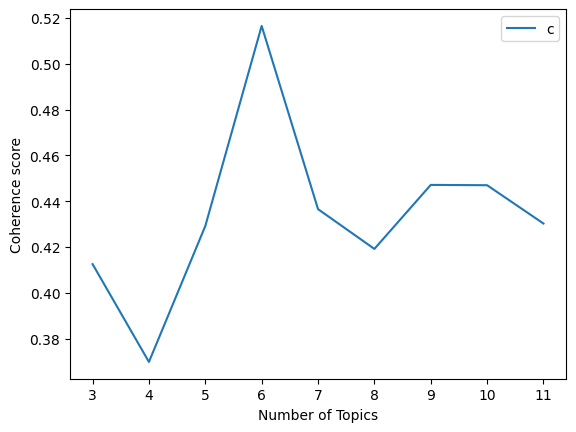


Silhouette Plot:



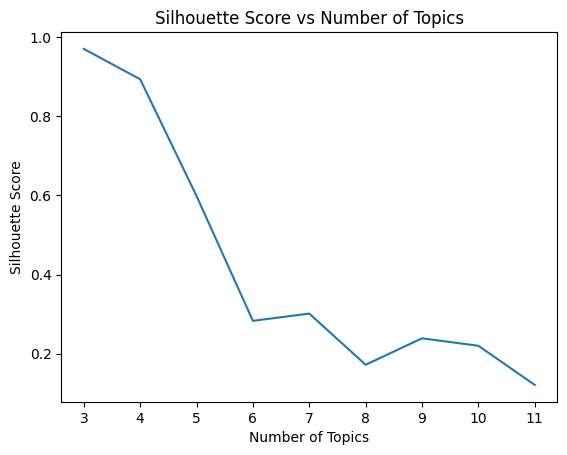


Variance Explained Plot:



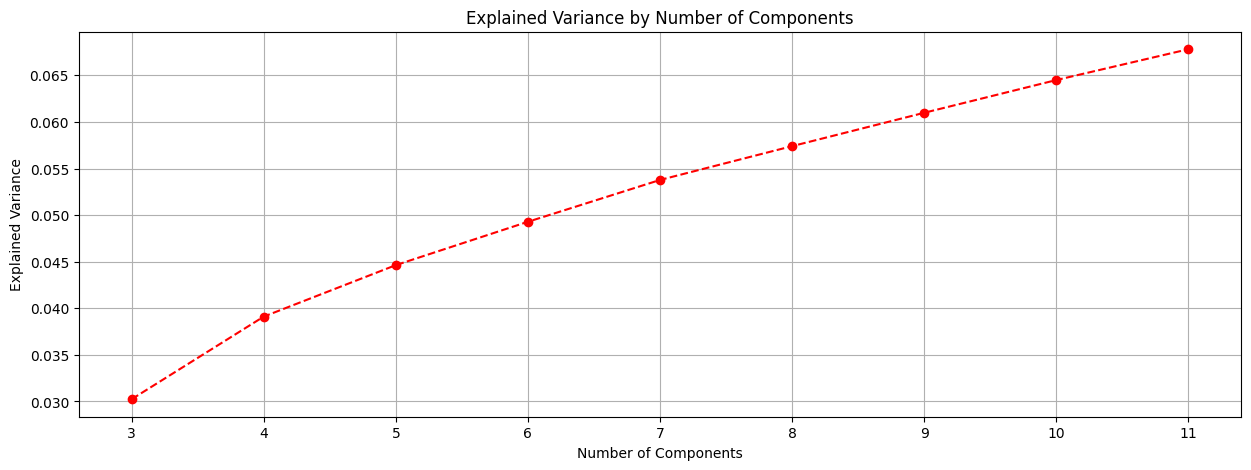

Optimal number of components by Explained Variance: 4

 Topic Diversity Plot:



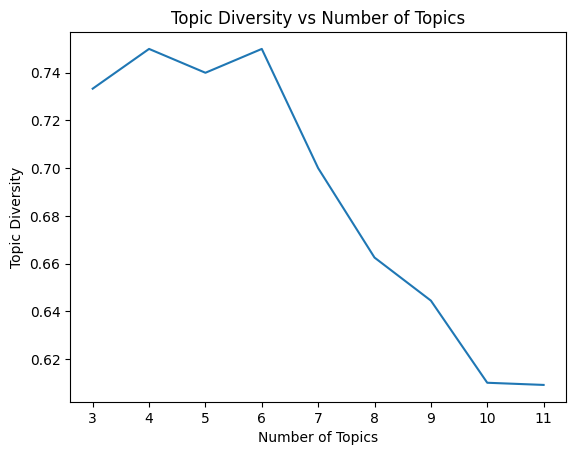

In [ ]:
# Metrics
#Uncomment below if using colab
#file_path = 'clean_ovp_budget.csv'

#Uncomment below if using kaggle notebook
file_path = '/kaggle/input/lsa-ovp/clean_ovp_budget.csv'
text_column = 'Content'

start, stop, step = 3, 12, 1
COHERENCE_METRIC_1 = 'c_v'
document_list = load_data_from_csv(file_path, text_column)
tokenized_text = tokenize_docs(document_list)
grammed_docs = phrasing(tokenized_text)

# Coherence c_v Values Plot:
print("\nCoherence Plot for c_v:\n")
plot_graph(grammed_docs, COHERENCE_METRIC_1, start, stop, step)

# Silhouette Score Plot:
print("\nSilhouette Plot:\n")
plot_silhouette_scores(grammed_docs, start, stop, step)

# Variance Explained Plot:
print("\nVariance Explained Plot:\n")
ovp_budget = pd.read_csv(file_path)
plot_variance_explained(ovp_budget, start, stop, step)

# Topic Diversity Plolt:
print("\n Topic Diversity Plot:\n")
plot_topic_diversity_scores(grammed_docs, start, stop, step, top_n_words = 10)

In [ ]:
# LSA Model
number_of_topics = 6
words = 15
lsa_model, dictionary, tfidf_matrix = create_gensim_lsa_model(
    grammed_docs, number_of_topics, words)

Topic 0:
	0.749*"european_parliament"
	0.468*"parliament_european"
	0.335*"council_european"
	0.327*"parliament_council"
	0.011*"form_communication"
	0.010*"commission"
	0.010*"provide_commission"
	0.009*"parliament"
	0.001*"common_position"
	0.001*"implementation_common"
	0.000*"implementation_european"
	0.000*"council"
	0.000*"position"
	0.000*"european_union"
	0.000*"talk"

Topic 1:
	-0.807*"parliament_european"
	0.578*"european_parliament"
	-0.093*"council_european"
	-0.071*"parliament_council"
	-0.024*"parliament"
	-0.002*"commission"
	0.002*"common_position"
	0.002*"implementation_common"
	0.001*"implementation_european"
	0.001*"council"
	0.001*"position"
	-0.001*"form_communication"
	-0.001*"provide_commission"
	0.001*"european_union"
	0.000*"talk"

Topic 2:
	0.987*"datum_source"
	0.092*"datum_datum"
	0.049*"fund"
	0.040*"family"
	0.039*"source_datum"
	0.037*"pork_barrel"
	0.032*"budget"
	0.025*"decision"
	0.023*"discretionary"
	0.018*"unusual"
	0.016*"office"
	0.016*"congress"


Due to the similarities of topics 0 and 1, the proponents merged both of them as one topic

In [ ]:
def get_topic_words(model):
    topic_words = {}
    for i in range(model.num_topics):
        words = model.show_topic(i, topn = 15)
        topic_words[i] = [word for word, _ in words]
    return topic_words

In [ ]:
'''
  Labels each documents in the dataframe with the corresponding topic based on
  its `most likely` topic (based on topic scores provided by the Gensim model).

'''
def auto_label_documents(df, column, model):
    # Setting the combined topics (0 & 1)
    combined_topics = {
      0: 1,
      1: 1
    }

    topic_words = get_topic_words(model)
    labels = []

    for content in df[column]:
        content_words = set(content.lower().split())
        # Dictionary to keep track of scores for each topic
        topic_scores = defaultdict(int)

        # Count occurrences of topic words in the content
        for topic, words in topic_words.items():
            for word in words:
                if word in content_words:
                    topic_scores[topic] += 1

        # Determine the topic with the highest score
        if topic_scores:
            assigned_label = max(topic_scores, key = topic_scores.get)
            # If the assigned label is part of combined topic 0 & 1; map it
            if assigned_label in combined_topics:
              assigned_label = combined_topics[assigned_label]
            labels.append(int(assigned_label))
        else:
            labels.append(None)  # If no topic words are found

    return labels

In [ ]:
'''
  Labels each documents in the dataframe with the corresponding topic based on
  its `most likely` topic (based on topic scores provided by the Gensim model).

'''
def label_corpus(model, tfidf_matrix, df, column_name):
  combined_topics = {
    0: 1,
    1: 1
  }

  doc_labels = []
  for idx, doc in enumerate(df[column_name]):
    topic_score = model[tfidf_matrix[idx]]

    if topic_score:
      # Gets the highest topic score arranged in descending order
      best_topic_score = max(topic_score, key = lambda x: x[1])
      if best_topic_score in combined_topics:
        best_topic_score = combined_topics[best_topic_score]
      # Adds the topic with the highest topic score
      doc_labels.append(best_topic_score[0])
    else:
        # No labels found :((
        doc_labels.append(None)
  return doc_labels

In [ ]:
# Data labelling
CONTENT_COLUMN = 'Content'
ovp_budget['Topic'] = auto_label_documents(ovp_budget,
                                           CONTENT_COLUMN,
                                           lsa_model)
ovp_budget = ovp_budget.dropna()
ovp_budget

Original  \
0     The Makabayan bloc members of the House of Rep...   
1     Senator Risa Hontiveros  calls for a Senate  p...   
2     The Department of Education's finance unit is ...   
3     Senator Risa Hontiveros calls for a Senate pro...   
4     HINDI PWEDENG MAGHUGAS KAMAY'\n\nSen. Risa Hon...   
...                                                 ...   
3274  Zero budget for zero results.\n\nJust what the...   
3275  I remember pag budget hearing ng OVP under Len...   
3279  Hindi pwedeng zero. Obligado silang bigyan lah...   
3280  parang parehas may alas si swoh maapprove man ...   
3281  At the time of PRRD walang bias sa pagbigay ng...   

                                                Content  Topic  
0     bloc house vice president sarah answer extreme...    3.0  
1     senator laugh senate probe sarah spend confide...    3.0  
2     department education finance unit aware vice p...    3.0  
3     senator laugh senate probe vice president sara...    3.0  
4     wash hand sen laugh senate select committee co...    3.0  
...                                                 ...    ...  
3274                                        budget brat    2.0  
3275  remember budget hearing leni congress clean bu...    2.0  
3279                               oblige budget budget    2.0  
3280  parang alas approval budget fall fall reductio...    2.0  
3281                             time bias budget enemy    2.0  

[2463 rows x 3 columns]

In [ ]:
def display_docs_topic(df, model, topic_column, doc_column, n):
  topics = sorted(df[topic_column].unique())
  for topic in topics:
    print(f"\n\nTopic {topic}:")
    # Takes docs belonging to current topic
    topic_docs = df[df[topic_column] == topic][doc_column]
    # Random selection/sampling of `n` documents for each topic
    sampled_docs = topic_docs.sample(n = min(n, len(topic_docs)),
                                    random_state = 45)

    for idx, doc in enumerate(sampled_docs, 1):
      print(f"\nDocument {idx}:")
      print(doc)
    print('--------------------------------------')

TOPIC_COLUMN = 'Topic'
DOCUMENT_COLUMN = 'Content'
num_docs = 5
display_docs_topic(ovp_budget, lsa_model, TOPIC_COLUMN, DOCUMENT_COLUMN, num_docs)



Topic 1.0:

Document 1:
brave sarah stick plan force budget hey cocoa sad yang source talk budget san sea read winner evil plan

Document 2:
provide commission form communication european union implementation european common agricultural policy common agricultural policy

Document 3:
impeach sarah provide commission official journal european union

Document 4:
embarrass tao queen provide commission form communication commission

Document 5:
provide commission form communication commission
--------------------------------------


Topic 2.0:

Document 1:
congress fair subject cif drill fund transparent public accountable conform mandate constitution congress public law commission audit publish annually list truth complicate complex truth

Document 2:
peso budget ogre

Document 3:
object bad budget hearing bad disgust bad steal money town

Document 4:
backdoor late fund

Document 5:
wow beautiful sarah nag split hearing return office
--------------------------------------


Topic 3.0:



In [ ]:
# Saving the labelled dataframe with respective labels
ovp_budget.to_csv('labeled_ovp.csv')

# Visualizations

In [ ]:
#Re-reading the labeled dataframe
# Uncomment code below if on Colab
#labeled_path = 'labeled_ovp.csv'
# Uncomment code below if on kaggle
labeled_path = '/kaggle/input/lsa-ovp/labeled_ovp.csv'
ovp_budget = pd.read_csv(labeled_path)
ovp_budget = ovp_budget.drop(columns = ['Unnamed: 0'], errors = 'ignore')
ovp_budget = ovp_budget.drop(columns = ['Original'], errors = 'ignore')
ovp_budget

Content  Topic
0     bloc house vice president sarah answer extreme...      3
1     senator laugh senate probe sarah spend confide...      3
2     department education finance unit aware vice p...      3
3     senator laugh senate probe vice president sara...      3
4     wash hand sen laugh senate select committee co...      3
...                                                 ...    ...
2458                                        budget brat      2
2459  remember budget hearing leni congress clean bu...      2
2460                               oblige budget budget      2
2461  parang alas approval budget fall fall reductio...      2
2462                             time bias budget enemy      2

[2463 rows x 2 columns]

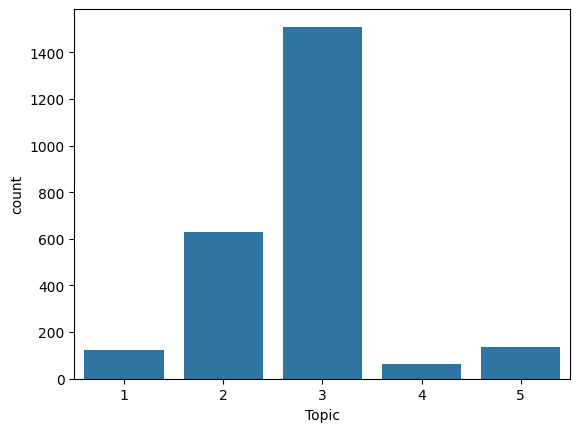

Topic
3    1510
2     628
5     138
1     123
4      64
Name: count, dtype: int64


In [ ]:
sns.countplot(x = 'Topic', data = ovp_budget)
plt.show()
print(f"{ovp_budget['Topic'].value_counts()}")

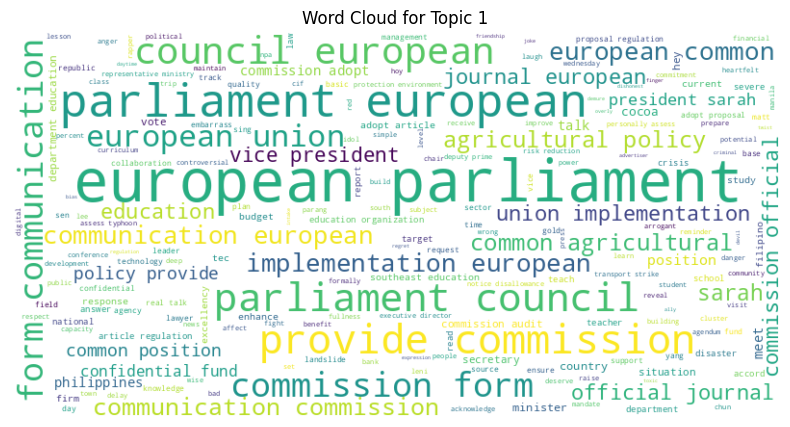

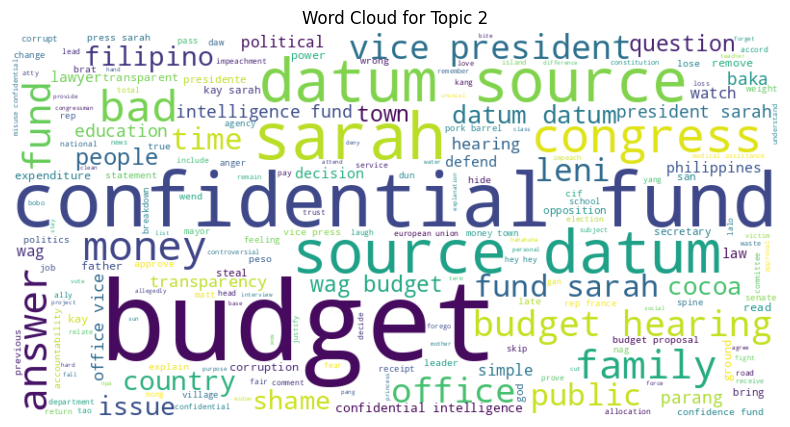

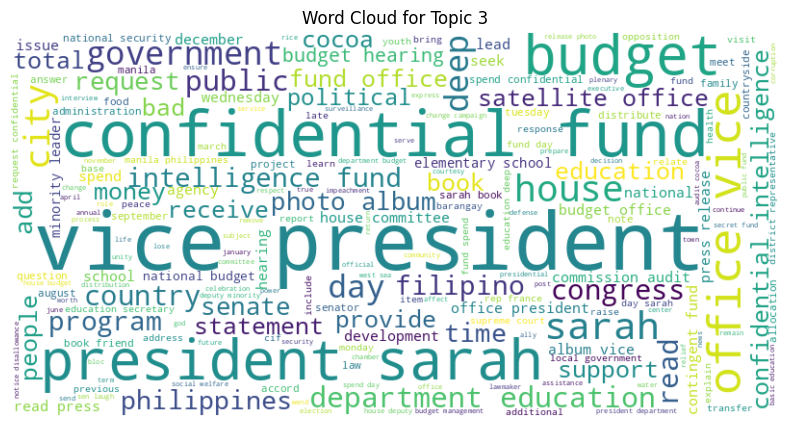

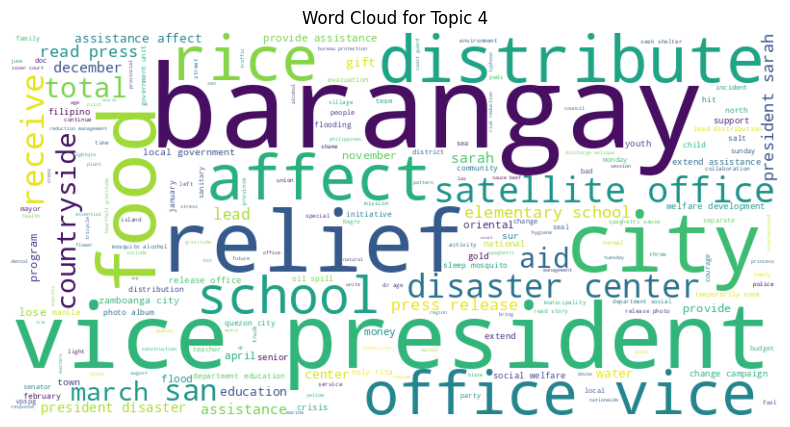

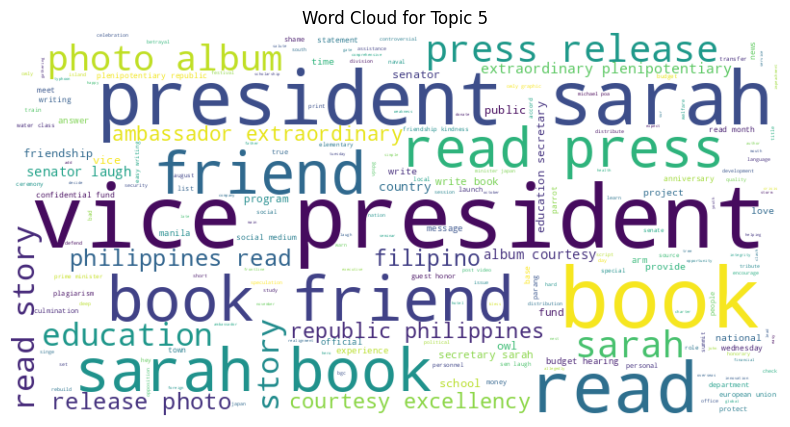

In [ ]:
# Get the unique classes from the 'Topic' column
topics = sorted(ovp_budget['Topic'].unique())

for topic in topics:
    # Filter the dataframe for each topic
    topic_text = ' '.join(ovp_budget[ovp_budget['Topic'] == topic]['Content'].astype(str))

    # Wordcloud object for visualizing the words that occur in each topic
    wordcloud = WordCloud(width = 800,
                          height = 400,
                          background_color = 'white').generate(topic_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(f"Word Cloud for Topic {topic}")
    plt.axis('off')
    plt.show()

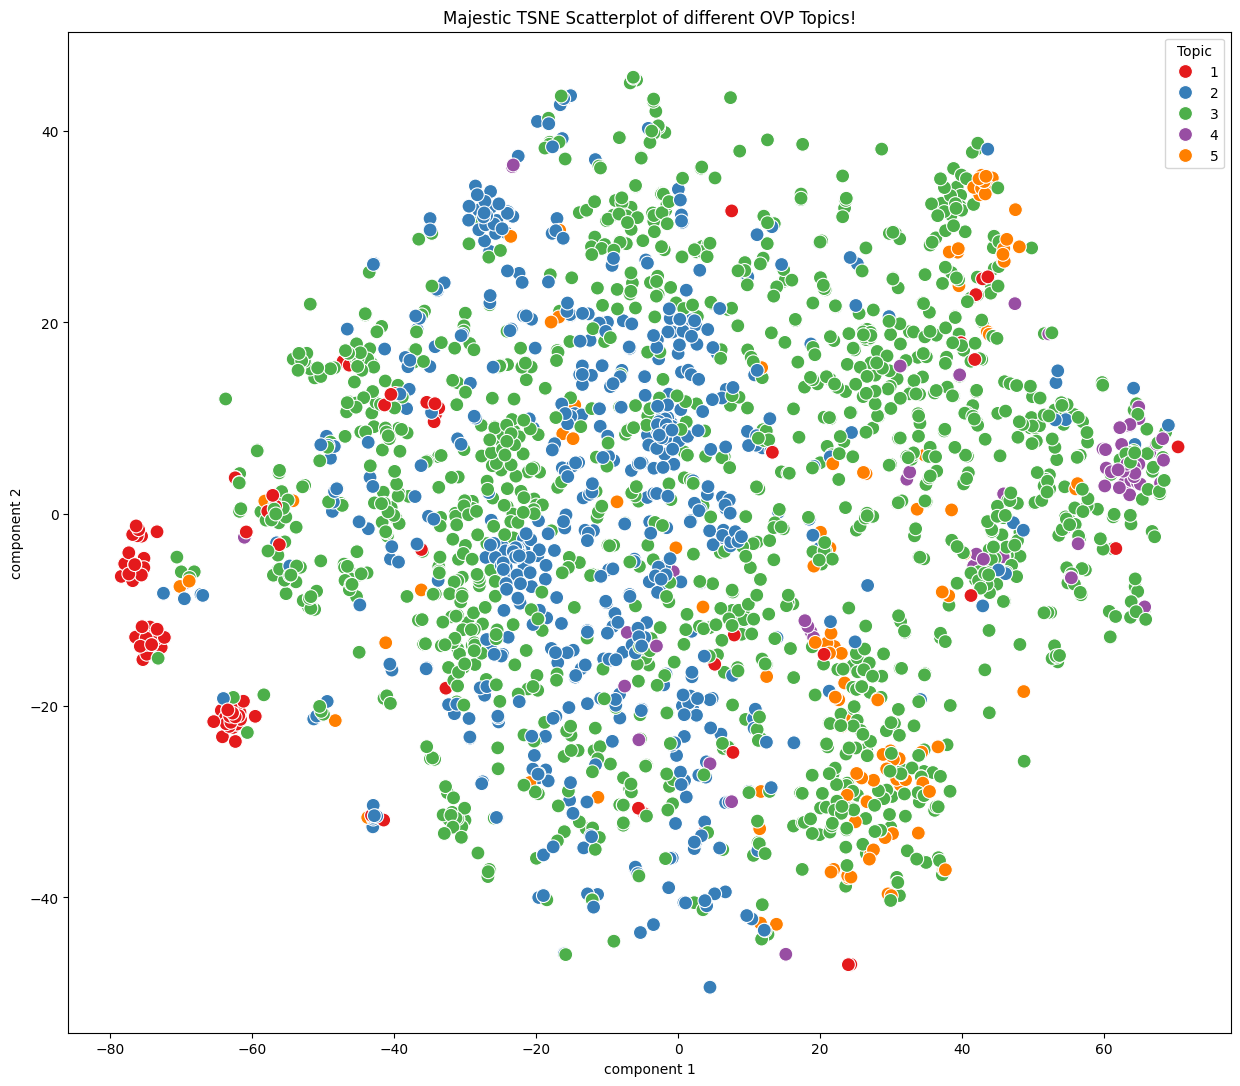

In [ ]:
# TSNE for visualizng the clusters:
vis_vectorizer = TfidfVectorizer(max_features = 1000)
X = vis_vectorizer.fit_transform(ovp_budget['Content'].astype(str)).toarray()
tsne = TSNE(n_components = 2,
           random_state = 42,
           perplexity = 30,
           n_iter = 1000)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(X_tsne, columns = ['component 1', 'component 2'])
tsne_df['Topic'] = ovp_budget['Topic']

plt.figure(figsize = (15, 13))
sns.scatterplot(x = 'component 1', y = 'component 2',
                hue = 'Topic', palette = "Set1",
                data = tsne_df, legend = "full", s = 100)
plt.title("Majestic TSNE Scatterplot of different OVP Topics!")
plt.show()

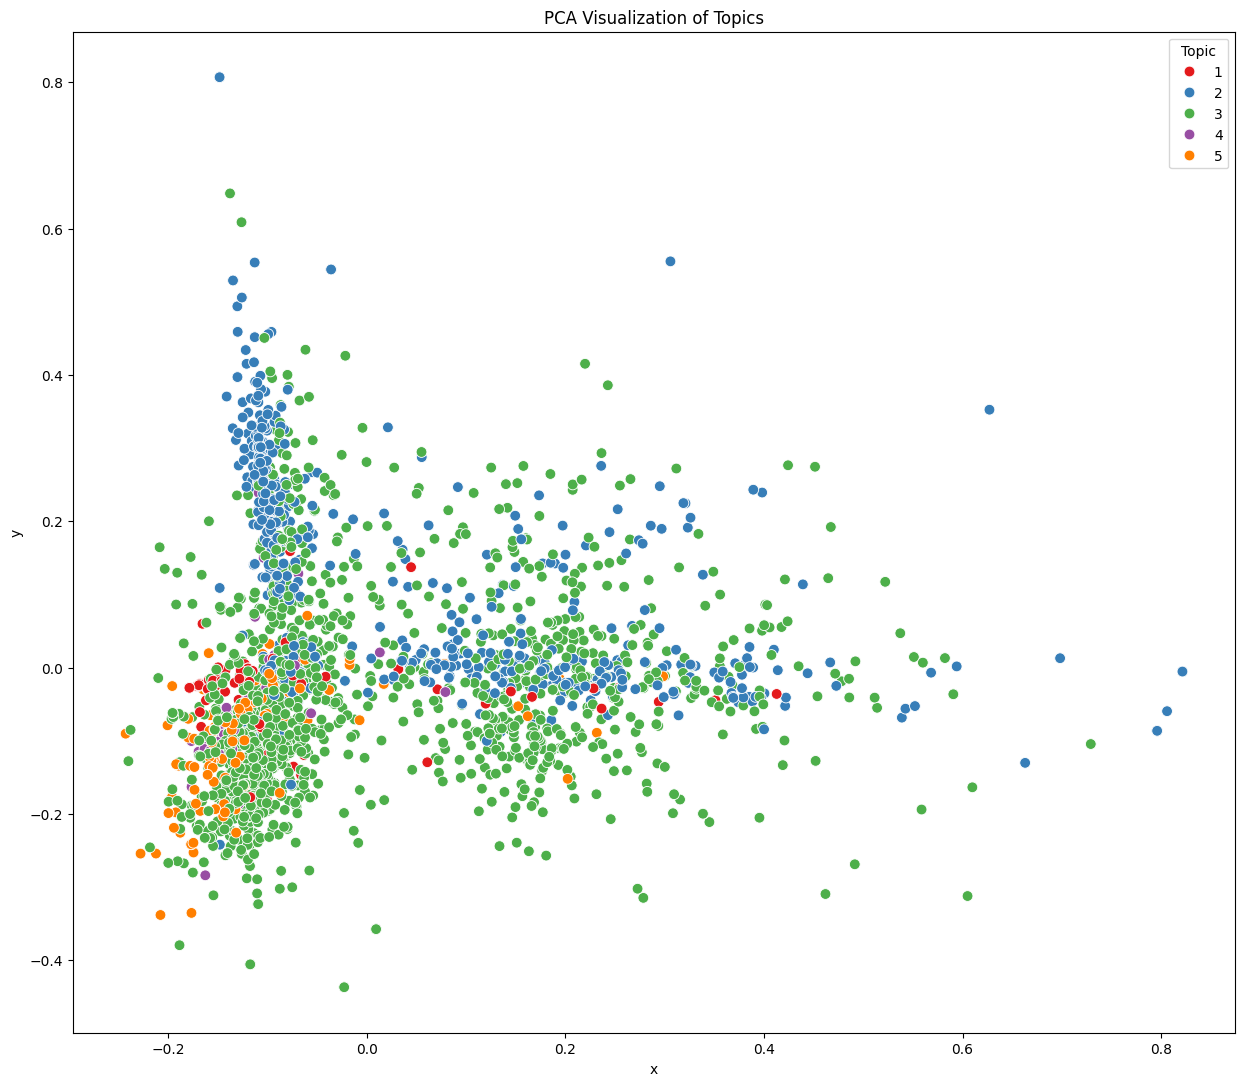

In [ ]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components = 2)
X_pca = pca_model.fit_transform(X)
pca_df = pd.DataFrame(X_pca, columns = ['x', 'y'])
pca_df['Topic'] = ovp_budget['Topic']

# Plotting
plt.figure(figsize=(15, 13))
sns.scatterplot(x = 'x', y = 'y', hue = 'Topic',
                palette = 'Set1', data = pca_df,
                legend='full', s = 60)

plt.title("PCA Visualization of Topics")
plt.show()